In [298]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

In [299]:
try:
    swaps_df = pd.read_csv("./data/astro/swaps.csv")
    swaps_df.timestamp = pd.to_datetime(swaps_df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    swaps_df = None

In [300]:
try:
    balances_df = pd.read_csv('./data/astro/balances_20230720_polished.csv')
    balances_df['traderAddress'] = balances_df['address']
except Exception as e:
    print(f"No file yet {e}")
    balances_df = None

In [301]:
all_astro_addresses_df = balances_df.address

In [302]:
_sell = swaps_df[swaps_df.offerAsset=='ASTRO']
_buy = swaps_df[swaps_df.returnAsset=='ASTRO']
_sell['astro_amount'] =  - _sell.offerAmount
_buy['astro_amount'] =  _buy.returnAmount
swaps_df = pd.concat([_sell, _buy])

/tmp/ipykernel_107/142230925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _sell['astro_amount'] =  - _sell.offerAmount
/tmp/ipykernel_107/142230925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _buy['astro_amount'] =  _buy.returnAmount


### Focus

swaps_df[swaps_df.traderAddress=='terra19k3s3gv5pfm3kh4utry9ty0hsulc2n8sv5shu8']\
    .sort_values(by='astro_amount', ascending=False).astro_amount.sum()

### Balances

tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

addresses = set(df.traderAddress.tolist())

balances = []
for address in addresses:
    try:
        balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(address)['data']['tokenBalances'])}
        balance_dict['traderAddress']= address
        balances.append(balance_dict)
    except:
        print(f"Error processing: {address}")

balances_df = pd.DataFrame(balances)
balances_df['total_astro_holdings'] = balances_df['ASTRO'] + balances_df['xASTRO']

df_ = pd.DataFrame(balances_df).merge(df, on='traderAddress')

### Rest of analysis

<Axes: >

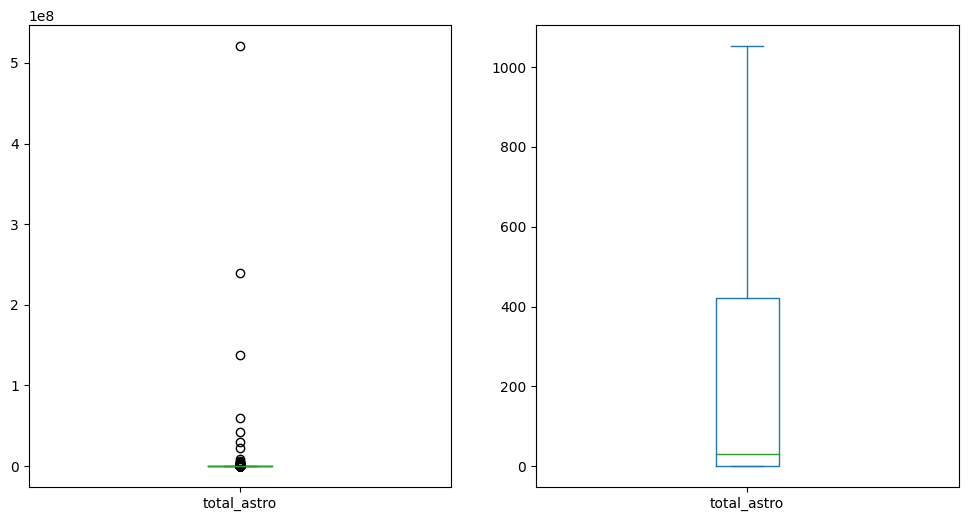

In [303]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
balances_df.total_astro.plot(kind='box', ax=axes[0])
balances_df.total_astro.plot(kind='box', showfliers=False, ax=axes[1])

balances_df.total_astro.sort_values().cumsum().reset_index(drop=True).plot(kind='line')

In [304]:
percentile = 0.99

In [305]:
astro_price = 0.022

In [306]:
balances_df.total_astro.quantile(percentile) * astro_price

2594.1471716538367

In [307]:
whales = balances_df[balances_df.total_astro > balances_df.total_astro.quantile(percentile)]
whales.head()

,address,xASTRO,ASTRO,total_astro,traderAddress
103,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc,191454.14,0.00,191454.14,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc
126,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl,394043.59,0.00,394043.59,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl
174,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,2813275.72,109491.83,2922767.55,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf
186,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6,286106.94,0.00,286106.94,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6
188,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu,470615.83,5294.65,475910.48,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu


In [308]:
len(whales)

200

In [309]:
daily_delta = swaps_df[['traderAddress','date','astro_amount']].groupby(['traderAddress','date']).sum().reset_index()

In [310]:
daily_delta[["traderAddress","astro_amount"]]\
    .groupby(['traderAddress']).sum().reset_index()\
    .sort_values(by='astro_amount').head()

,traderAddress,astro_amount
118,terra147vzdxzn5tq4fm7z6f5q8x46xfha7e34w4sy9j,-1287925.34
484,terra1evtkrqahmavh4t5x6squzpwfcr4nl5ssj67edz,-1089543.75
41,terra129atwlwg5dwuypmce92gz7y5rwzdyxlwd8ne9r,-836005.66
782,terra1pgvewpk8kd30f2zm85sn69k9cgkp3j8szq00j7,-785389.82
98,terra13vr7ewxzvaz6nj299qqt0d6w0qwqjwhu53xnrh,-756129.57


In [311]:
whales.head()

,address,xASTRO,ASTRO,total_astro,traderAddress
103,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc,191454.14,0.00,191454.14,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc
126,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl,394043.59,0.00,394043.59,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl
174,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,2813275.72,109491.83,2922767.55,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf
186,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6,286106.94,0.00,286106.94,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6
188,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu,470615.83,5294.65,475910.48,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu


In [312]:
whales_movements_first_july = whales.merge(daily_delta[daily_delta.date>='2023-07-01']\
                                        .traderAddress.value_counts().reset_index(),
                                               on='traderAddress', how='left').fillna(0)
whales_movements_first_july.head()

,address,xASTRO,ASTRO,total_astro,traderAddress,count
0,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc,191454.14,0.00,191454.14,terra1juavpfk7j93zzey4skyqqpsnwpa5jhyg9rdytc,0.00
1,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl,394043.59,0.00,394043.59,terra10sxxa5vw34geymnqmyjmwugnsc6wput8c8p5zl,0.00
2,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,2813275.72,109491.83,2922767.55,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,1.00
3,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6,286106.94,0.00,286106.94,terra1tcttlvp753axe9cqek995gswwjkx4hcwxupep6,0.00
4,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu,470615.83,5294.65,475910.48,terra1qweasagmfvgxdz8jjg2xk7llgftfuu7y9gv5hu,0.00


<Axes: xlabel='count'>

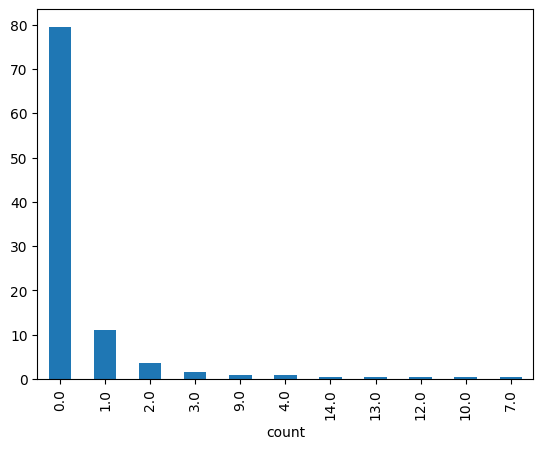

In [313]:
(whales_movements_first_july['count'].value_counts(normalize=True)*100).plot(kind='bar')

In [314]:
total_delta_astro = daily_delta[daily_delta.date>='2023-07-01']\
                    [['traderAddress','astro_amount']]\
                    .groupby('traderAddress')\
                    .sum()

In [315]:
total_delta_astro = daily_delta[daily_delta.date>='2023-07-01']\
                    [['traderAddress','astro_amount']]\
                    .groupby('traderAddress')\
                    .sum()

In [316]:
whales_delta = whales.merge(total_delta_astro, on='traderAddress', how='left').fillna(0)

<Axes: xlabel='traderAddress'>

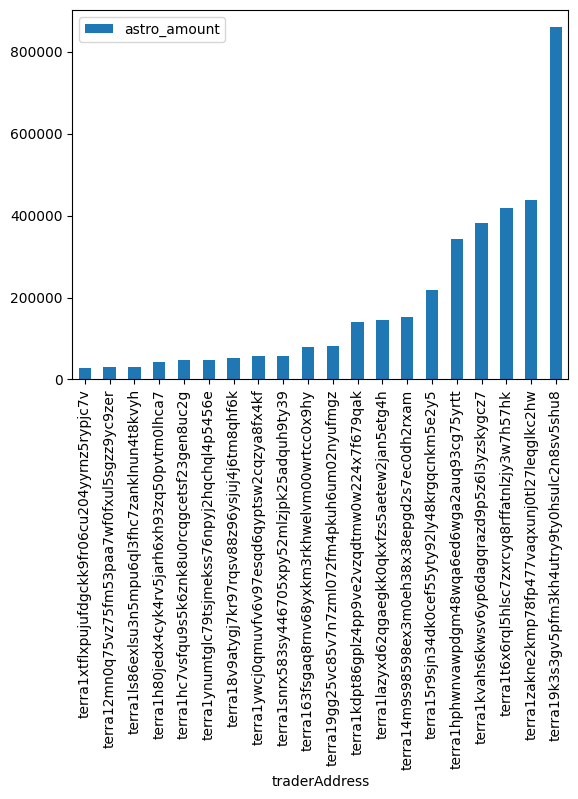

In [317]:
dd = whales_delta[['traderAddress','astro_amount']]\
        .sort_values(by='astro_amount', ascending=True).tail(20)
dd.set_index('traderAddress').plot(kind='bar')

In [318]:
dd

,traderAddress,astro_amount
154,terra1xtflxpujufdgckk9fr06cu204yyrnz5rypjc7v,28425.15
49,terra12mn0q75vz75fm53paa7wf0fxul5sgzz9yc9zer,29265.61
101,terra1ls86exlsu3n5mpu6ql3fhc7zanklnun4t8kvyh,30575.58
156,terra1h80jedx4cyk4rv5jarh6xh93zq50pvtm0lhca7,41591.17
6,terra1hc7vsfqu9s5k6znk8u0rcqgcetsf23gen8uc2g,46461.59
140,terra1ynumtglc79tsjmekss76npyj2hqchql4p5456e,47295.43
53,terra18v9atygj7kr97rqsv88z96ysjuj4j6tm8qhf6k,53015.66
2,terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,56875.01
71,terra1snrx583sy446705xpy52mlzjpk25adquh9ty39,57868.90
11,terra163fsgaq8rnv68yxkm3rkhwelvm00wrtcc0x9hy,79570.06


<Axes: xlabel='traderAddress'>

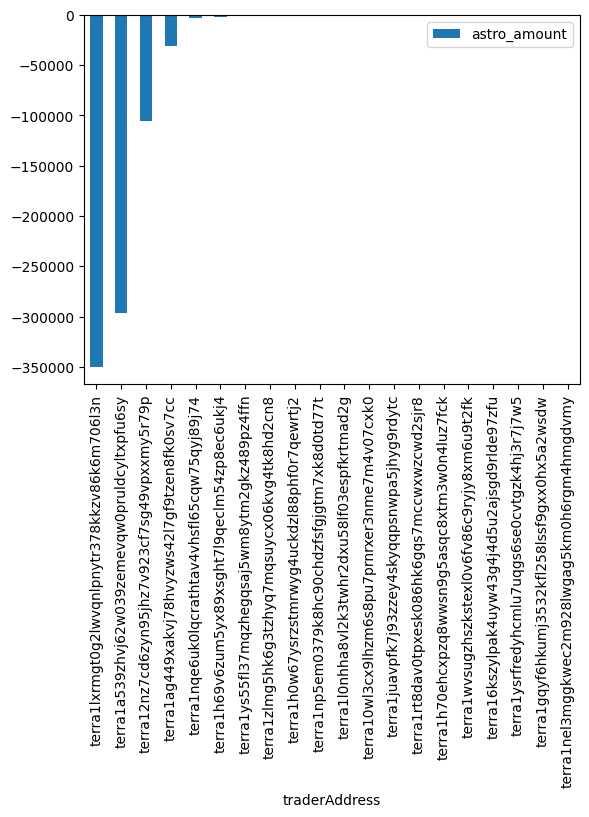

In [319]:
dd = whales_delta[['traderAddress','astro_amount']]\
        .sort_values(by='astro_amount', ascending=True).head(20)
dd.set_index('traderAddress').plot(kind='bar')

In [320]:
dd[dd.astro_amount<0]

,traderAddress,astro_amount
76,terra1lxrmgt0g2lwvqnlpnytr378kkzv86k6m706l3n,-350000.00
95,terra1a539zhvj62w039zemevqw0pruldcyltxpfu6sy,-296496.81
128,terra12nz7cd6zyn95jhz7v923cf7sg49vpxxmy5r79p,-105537.00
80,terra1ag449xakvj78hvyzws42l7gf9tzen8fk0sv7cc,-31297.89
88,terra1nqe6uk0lqcrathtav4vhsfl65cqw75qyj89j74,-3496.28
124,terra1h69v6zum5yx89xsght7l9qeclm54zp8ec6ukj4,-2195.86


In [321]:
def xx(x):
    if x > 100:
        return 'buyer'
    if x < -100:
        return 'seller'
    if x > -100 and x < 100:
        return 'holders'
whales_delta['whale_type'] = whales_delta.astro_amount.apply(xx)

<Axes: ylabel='count'>

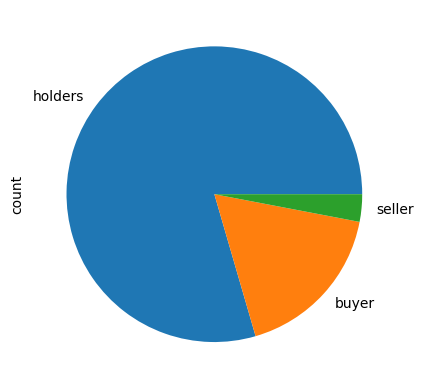

In [322]:
whales_delta.whale_type.value_counts().plot(kind='pie')

In [323]:
whales_delta.whale_type.value_counts(normalize=True)

whale_type
holders   0.80
buyer     0.17
seller    0.03
Name: proportion, dtype: float64

In [324]:
whales_delta[whales_delta.whale_type!='holders'].whale_type.value_counts(normalize=True)

whale_type
buyer    0.85
seller   0.15
Name: proportion, dtype: float64

<Axes: xlabel='whale_type'>

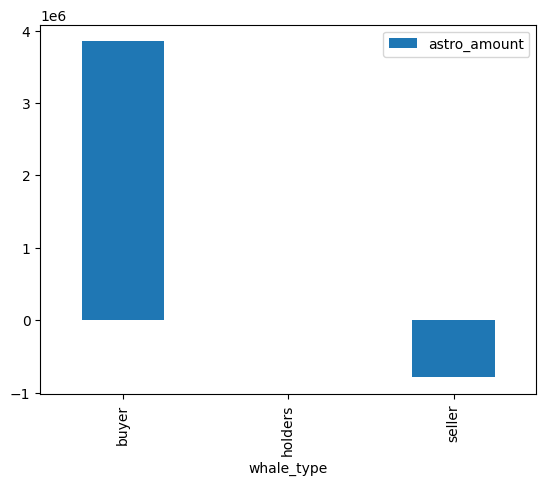

In [325]:
dd = whales_delta[['whale_type','astro_amount']].groupby('whale_type').sum()
dd.plot(kind='bar')

In [326]:
dd

,astro_amount
whale_type,
buyer,3849959.30
holders,0.00
seller,-789023.84


In [327]:
whales_daily = whales.merge(daily_delta[daily_delta.date>='2023-07-01'],on='traderAddress', how='left').fillna(0)

In [328]:
whales_daily[whales_daily.astro_amount != 0]\
    [['address','date']]\
    .groupby('address').min().sort_values(by='date', ascending=False)

,date
address,
terra1ld4yf48eqex65vdrt3kta23cvrx865zyfkgkka,2023-07-24
terra1ywcj0qmuvfv6v97esqd6qyptsw2cqzya8fx4kf,2023-07-21
terra13emdyum6s7v3vaew833euut7fd9ggw780ut3sj,2023-07-18
terra15r9sjn34dk0cef55yty92ly48krgqcnkm5e2y5,2023-07-17
terra1ntalwpt99yk4dkprpqq6alrs67saqfjkdn6d2c,2023-07-17
terra19gg25vc85v7n7zml072fm4pkuh6um02nyufmgz,2023-07-17
terra1kvahs6kwsv6yp6dagqrazd9p5z6l3yzskygcz7,2023-07-17
terra1h69v6zum5yx89xsght7l9qeclm54zp8ec6ukj4,2023-07-14
terra1k6hrpxdfzesxc2wm78ele9xlg6na3knky6cx0k,2023-07-14


In [329]:
whales_daily[whales_daily.address=='terra1ld4yf48eqex65vdrt3kta23cvrx865zyfkgkka']

,address,xASTRO,ASTRO,total_astro,traderAddress,date,astro_amount
234,terra1ld4yf48eqex65vdrt3kta23cvrx865zyfkgkka,157688.19,0.00,157688.19,terra1ld4yf48eqex65vdrt3kta23cvrx865zyfkgkka,2023-07-24,3881.85


In [330]:
swaps_df[(swaps_df.traderAddress=='terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp')&\
            (swaps_df.date=='2023-07-24')]

,txHash,timestamp,traderAddress,offerAsset,offerAmount,offerAssetUsdPrice,returnAsset,returnAmount,returnAssetUsdPrice,isHallSwap,usdVolume,date,blockId,astro_amount
15717,CC32C39F856C72882EBD43C4ECA5125DBC5CA886C4AE65AD8BF0FA08DFDA063E,2023-07-24 12:41:27.667000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6686.93,0.02,axlUSDC,148.87,1.00,False,148.75,2023-07-24,6080005.00,-6686.93
15770,665B1EE2B10954C2E4D373697E3B7B8815DC484A284A54581387EF074CE8D5DF,2023-07-24 09:27:33.469000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6595.49,0.02,axlUSDC,148.60,1.00,False,148.70,2023-07-24,6078071.00,-6595.49
15827,0196FF9C855BD0D4BB1B078FB94260CCF2A884B99F8B36FA3D199301303002F2,2023-07-24 00:14:44.769000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6545.57,0.02,axlUSDC,148.95,1.00,False,148.97,2023-07-24,6072562.00,-6545.57
16150,CC32C39F856C72882EBD43C4ECA5125DBC5CA886C4AE65AD8BF0FA08DFDA063E,2023-07-24 12:41:27.667000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6686.93,0.02,axlUSDC,148.87,1.00,False,148.75,2023-07-24,6080005.00,-6686.93
16206,665B1EE2B10954C2E4D373697E3B7B8815DC484A284A54581387EF074CE8D5DF,2023-07-24 09:27:33.469000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6595.49,0.02,axlUSDC,148.60,1.00,False,148.70,2023-07-24,6078071.00,-6595.49
16263,0196FF9C855BD0D4BB1B078FB94260CCF2A884B99F8B36FA3D199301303002F2,2023-07-24 00:14:44.769000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,ASTRO,6545.57,0.02,axlUSDC,148.95,1.00,False,148.97,2023-07-24,6072562.00,-6545.57
15728,E9833CA54457C66E8900F86F3F12C755C588198933C7CC3E6687BD9965384F3B,2023-07-24 11:49:20.844000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,axlUSDC,150.00,1.00,ASTRO,6686.93,0.02,False,150.10,2023-07-24,6079485.00,6686.93
15816,3AC41BE1534B439291715526CAE0AB7945C646372F9681DFB74B33CF1FC8717B,2023-07-24 00:36:53.737000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,axlUSDC,150.00,1.00,ASTRO,6595.49,0.02,False,149.95,2023-07-24,6072782.00,6595.49
16112,1456BAE4377EA93628957B1D3B3B61021334E40113343EF02D492DD1ABD9F2D7,2023-07-24 16:26:58.200000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,axlUSDC,150.00,1.00,ASTRO,6700.82,0.02,False,150.05,2023-07-24,6082255.00,6700.82
16131,1456BAE4377EA93628957B1D3B3B61021334E40113343EF02D492DD1ABD9F2D7,2023-07-24 16:26:58.200000+00:00,terra15m7j76syfaz4n6u8tss7p5ufwfuhjk04g7z8mp,axlUSDC,150.00,1.00,ASTRO,6700.82,0.02,False,150.05,2023-07-24,6082255.00,6700.82
